In [1]:
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Define the preprocessing function for VGG19
def preprocess_input(img):
    img = vgg19_preprocess_input(img)
    return img

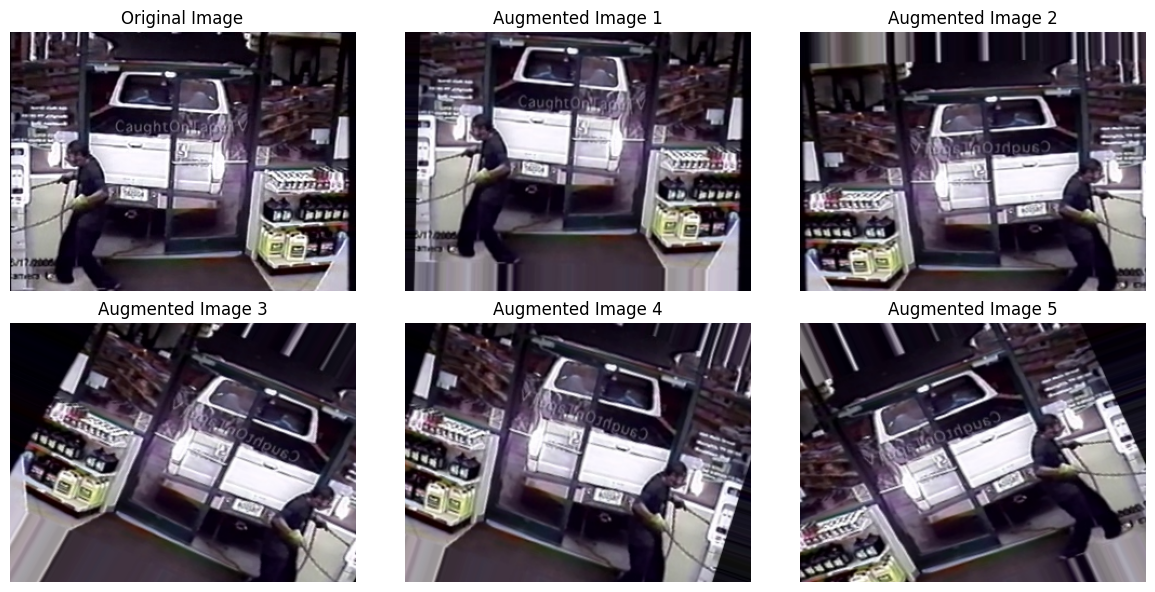

In [4]:
# Define the data generator with data augmentation
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load an example image
image_path = r'C:\Users\swadh\OneDrive\Desktop\crimedetection\Frames_for_Crime\Burglary\Burglary007_x264_fr0.jpg'
image = load_img(image_path, target_size=(240, 320))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(image_array[0].astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

aug_iter = data_generator.flow(image_array, batch_size=1)

# Display augmented images
for i in range(5):
    augmented_images = next(aug_iter)
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_images[0].astype(np.uint8))
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
BATCH_SIZE_TRAINING = 32
IMAGE_RESIZE = (240, 320)

# Define the training data generator
train_data_generator = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input
)

# Create the training data generator
train_generator = train_data_generator.flow_from_directory(
    r'C:\Users\swadh\OneDrive\Desktop\crimedetection',
    target_size=IMAGE_RESIZE,
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='binary',
    classes=['Frames_for_Crime', 'Frames_for_Normal']
)

print(f'Found {train_generator.samples} images belonging to {train_generator.num_classes} classes.')

Found 2230 images belonging to 2 classes.
Found 2230 images belonging to 2 classes.


In [6]:
print(f'train_gen.class_indices: {train_generator.class_indices}')


train_gen.class_indices: {'Frames_for_Crime': 0, 'Frames_for_Normal': 1}


In [7]:
# Define the VGG19 model
baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the base model layers
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
adam = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [8]:
# Early stopping callback
cb_early_stopper = EarlyStopping(monitor='loss', patience=4)


In [9]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = train_generator.samples // BATCH_SIZE_TRAINING

# Train the model
fit_history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    epochs=NUM_EPOCHS,
    callbacks=[cb_early_stopper]
)




Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 504s 7s/step - accuracy: 0.7078 - loss: 0.6041
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 282us/step - accuracy: 0.9062 - loss: 0.1853
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 507s 7s/step - accuracy: 0.9058 - loss: 0.2181
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 41us/step - accuracy: 1.0000 - loss: 0.1373
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 505s 7s/step - accuracy: 0.9341 - loss: 0.1869
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 0s/step - accuracy: 1.0000 - loss: 0.0387  
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 495s 7s/step - accuracy: 0.9571 - loss: 0.1100
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 135us/step - accuracy: 0.9062 - loss: 0.2130
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 498s 7s/step - accuracy: 0.9554 - loss: 0.1015
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 0s/step - accuracy: 0.9688 - loss: 0.0706  


In [11]:
print(fit_history.history.keys())

dict_keys(['accuracy', 'loss'])


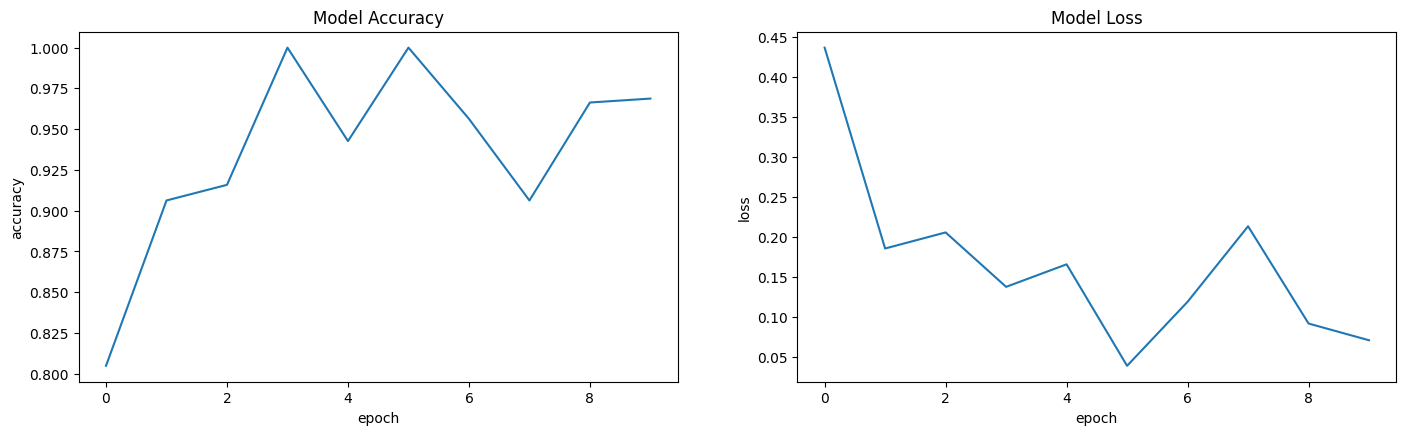

In [10]:
# Plot the training history
plt.figure(1, figsize=(17, 10))

plt.subplot(221)
plt.plot(fit_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()



In [12]:
test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create a generator for the test data
test_generator = test_data_generator.flow_from_directory(
    r'C:\Users\swadh\OneDrive\Desktop\crimedetection',
    target_size=IMAGE_RESIZE,
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='binary',
    classes=['test_crime', 'test_normal']
)

# Evaluate the model on the test data
evaluation = model.evaluate(test_generator)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


Found 556 images belonging to 2 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 127s 7s/step - accuracy: 0.9692 - loss: 0.0975
Test Loss: 0.10603494197130203, Test Accuracy: 0.971222996711731


In [13]:
model.save('C:/Users/swadh/OneDrive/Desktop/crimedetection/vgg19.h5')